In [11]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from datetime import datetime, timedelta

In [2]:
spark = (
    SparkSession.builder.master("local[*]")
    .appName(name="unittest")
    .config("spark.ui.enabled", "false")
    .config(
        "spark.driver.extraJavaOptions",
        "--add-exports java.base/sun.nio.ch=ALL-UNNAMED",
    )
    .config(
        "spark.jars.packages",
        "org.apache.hadoop:hadoop-azure:3.3.1,com.microsoft.azure:azure-storage:8.6.6",
    )
    .getOrCreate()
)

:: loading settings :: url = jar:file:/opt/homebrew/anaconda3/envs/goodnotes-insights-data-eng/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hongong/.ivy2/cache
The jars for the packages stored in: /Users/hongong/.ivy2/jars
org.apache.hadoop#hadoop-azure added as a dependency
com.microsoft.azure#azure-storage added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e4c86b9e-b7eb-4dec-9a72-eab59d7128f5;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-azure;3.3.1 in spark-list
	found org.apache.httpcomponents#httpclient;4.5.13 in spark-list
	found org.apache.httpcomponents#httpcore;4.4.13 in spark-list
	found commons-logging#commons-logging;1.1.3 in spark-list
	found commons-codec#commons-codec;1.11 in spark-list
	found org.apache.hadoop.thirdparty#hadoop-shaded-guava;1.1.1 in spark-list
	found org.eclipse.jetty#jetty-util-ajax;9.4.40.v20210413 in central
	found org.eclipse.jetty#jetty-util;9.4.40.v20210413 in central
	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in spark-list
	found org.

# Data loading

In [3]:
def load_and_prepare_data(spark, start_date, end_date):
    """Load and prepare the datasets with date filtering"""
    # Load user interactions data
    interactions_df = spark.read.csv(
        "data/user_interactions_sample.csv", header=True, inferSchema=True
    ).filter(F.col("timestamp").between(start_date, end_date))

    # Load user metadata
    metadata_df = spark.read.csv(
        "data/user_metadata_sample.csv", header=True, inferSchema=True
    )

    # Clean and validate data
    interactions_df = interactions_df.filter(
        F.col("duration_ms").between(0, 7200000)
    )  # Filter out sessions > 2 hours

    return interactions_df, metadata_df

In [4]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

# Load and prepare data
interactions_df, metadata_df = load_and_prepare_data(spark, start_date, end_date)

# Print the schema of the datasets
interactions_df.printSchema()
metadata_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- action_type: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- app_version: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- join_date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- subscription_type: string (nullable = true)



In [5]:
# show the first 5 rows of the datasets
interactions_df.show(5)

metadata_df.show(5)

+-------+-------------------+-----------+-------+-----------+-----------+
|user_id|          timestamp|action_type|page_id|duration_ms|app_version|
+-------+-------------------+-----------+-------+-----------+-----------+
|u918064|2023-04-16 22:13:09|      share|p971654|      16604|      7.6.9|
|u566384|2023-10-05 21:20:58|     create|p745500|     254573|      6.4.9|
|u740843|2023-04-20 12:22:53|      share|p498246|     254529|      6.5.8|
|u734451|2023-07-15 10:00:02|  page_view|p504399|     281675|      5.1.0|
|u811807|2023-10-17 13:40:29|     create|p644930|       5480|      7.2.4|
+-------+-------------------+-----------+-------+-----------+-----------+
only showing top 5 rows

+-------+----------+-------+--------------+-----------------+
|user_id| join_date|country|   device_type|subscription_type|
+-------+----------+-------+--------------+-----------------+
|u445162|2020-09-18|     MX|          iPad|             free|
|u608362|2020-06-04|     CA|        iPhone|            basic|

# Calculate Daily Active User (DAU) and Monthly Active User (MAU)

In [6]:
def calculate_active_users(
    self, fact_interactions: DataFrame, process_date: datetime, window_type: str = "day"
) -> DataFrame:
    """
    Calculate Daily/Monthly Active Users based on cleaned fact_interactions.

    Args:
        fact_interactions: DataFrame from silver layer fact table
        process_date: Date to process
        window_type: 'day' or 'month' for DAU/MAU calculation

    Returns:
        DataFrame with active user counts by date/month
    """
    if window_type == "day":
        # Daily active users calculation - use partition_date directly
        return (
            fact_interactions.filter(F.col("partition_date") == process_date)
            .groupBy("partition_date")
            .agg(
                F.countDistinct("user_id").alias("daily_active_users"),
                F.count("*").alias("total_actions"),
            )
            .orderBy("partition_date")
        )
    else:
        # Monthly active users calculation
        month_start = process_date.replace(day=1)
        month_end = (process_date + timedelta(days=32)).replace(day=1) - timedelta(
            days=1
        )

        return (
            fact_interactions.filter(
                F.col("partition_date").between(month_start, month_end)
            )
            .withColumn("month_date", F.date_trunc("month", F.col("partition_date")))
            .groupBy("month_date")
            .agg(
                F.countDistinct("user_id").alias("monthly_active_users"),
                F.count("*").alias("total_monthly_actions"),
            )
            .orderBy("month_date")
        )

In [7]:
# Calculate DAU
dau_df = calculate_active_users(interactions_df, "day")
dau_df.show(5)

+-------------+----------------+
|activity_date|day_active_users|
+-------------+----------------+
|   2023-01-01|            2799|
|   2023-01-02|            2692|
|   2023-01-03|            2692|
|   2023-01-04|            2746|
|   2023-01-05|            2654|
+-------------+----------------+
only showing top 5 rows



<Axes: title={'center': 'Daily Active Users'}, xlabel='activity_date'>

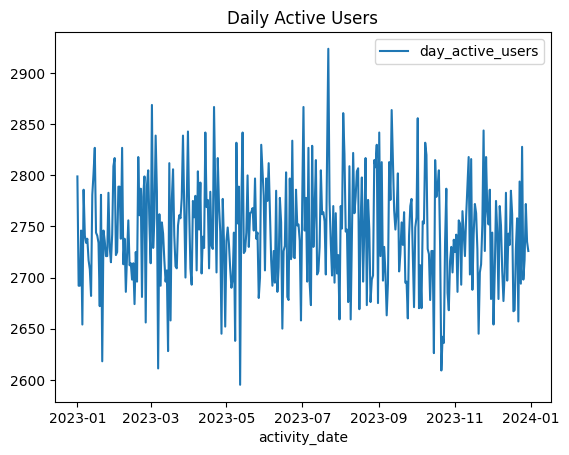

In [8]:
# plot the DAU
dau_df.toPandas().plot(
    x="activity_date", y="day_active_users", title="Daily Active Users"
)

In [9]:
# Calculate MAU
mau_df = calculate_active_users(interactions_df, "month")
mau_df.show(5)

+-------------------+------------------+
|      activity_date|month_active_users|
+-------------------+------------------+
|2023-01-01 00:00:00|             81534|
|2023-02-01 00:00:00|             73991|
|2023-03-01 00:00:00|             81703|
|2023-04-01 00:00:00|             79287|
|2023-05-01 00:00:00|             81605|
+-------------------+------------------+
only showing top 5 rows



<Axes: title={'center': 'Monthly Active Users'}, xlabel='activity_date'>

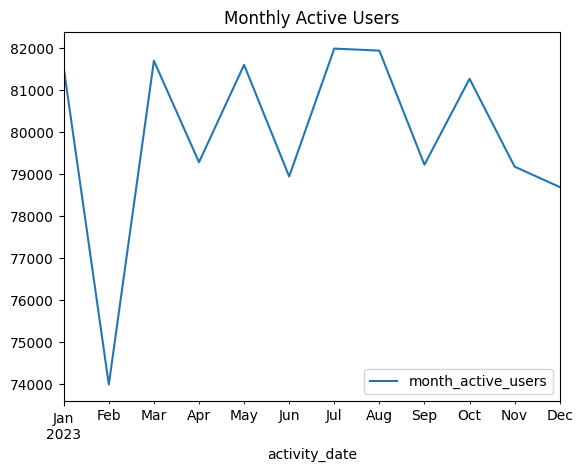

In [10]:
# plot the MAU
mau_df.toPandas().plot(
    x="activity_date", y="month_active_users", title="Monthly Active Users"
)

# Calculate session-based metrics

In [12]:
def identify_sessions(
    self,
    fact_interactions: DataFrame,
    process_date: datetime,
    lookback_days: int = 1,
    session_gap_minutes: int = 30,
) -> DataFrame:
    """
    Identify user sessions based on time gaps between actions with lookback period.

    Args:
        fact_interactions: DataFrame with user interactions
        process_date: Date to process
        lookback_days: Number of days to look back for ongoing sessions
        session_gap_minutes: Minutes of inactivity to consider a new session

    Returns:
        DataFrame with session information
    """
    # Calculate lookback period
    start_date = process_date - timedelta(days=lookback_days)

    # Create window specs for lag and cumulative operations
    user_window = Window.partitionBy("user_id").orderBy("timestamp")

    # Process interactions including lookback period
    return (
        fact_interactions.filter(
            F.col("partition_date").between(start_date, process_date)
        )
        .withColumn("prev_timestamp", F.lag("timestamp").over(user_window))
        .withColumn(
            "time_diff_minutes",
            F.when(
                F.col("prev_timestamp").isNotNull(),
                (F.unix_timestamp("timestamp") - F.unix_timestamp("prev_timestamp"))
                / 60,
            ).otherwise(0),
        )
        .withColumn(
            "is_new_session",
            F.when(F.col("time_diff_minutes") >= session_gap_minutes, 1).otherwise(0),
        )
        .withColumn(
            "session_id",
            F.concat(
                F.col("user_id"),
                F.lit("_"),
                F.date_format("partition_date", "yyyyMMdd"),
                F.lit("_"),
                F.sum("is_new_session").over(user_window),
            ),
        )
        .withColumn("next_timestamp", F.lead("timestamp").over(user_window))
        .withColumn(
            "session_end",
            F.when(
                F.col("next_timestamp").isNull()
                | (
                    (F.unix_timestamp("next_timestamp") - F.unix_timestamp("timestamp"))
                    / 60
                    >= session_gap_minutes
                ),
                True,
            ).otherwise(False),
        )
    )


def calculate_session_metrics(
    self, sessions_df: DataFrame, process_date: datetime
) -> DataFrame:
    """
    Calculate various session-based metrics for completed sessions.

    Args:
        sessions_df: DataFrame with session information
        process_date: Date to process

    Returns:
        DataFrame with session metrics
    """
    # Calculate base session metrics
    session_metrics = (
        sessions_df.filter(
            (F.col("partition_date") == process_date) | (F.col("session_end") == True)
        )
        .groupBy("session_id")
        .agg(
            F.count("*").alias("actions_per_session"),
            F.sum("duration_ms").alias("session_duration_ms"),
            F.first("partition_date").alias("session_date"),
            F.first("user_id").alias("user_id"),
            F.min("timestamp").alias("session_start"),
            F.max("timestamp").alias("session_end"),
            F.collect_set("action_type").alias("action_types"),
        )
    )

    # Add derived metrics
    enriched_metrics = (
        session_metrics.withColumn(
            "session_duration_minutes", F.round(F.col("session_duration_ms") / 60000, 2)
        )
        .withColumn("unique_action_types", F.size("action_types"))
        .withColumn("session_hour", F.hour(F.col("session_start")))
    )

    return enriched_metrics

In [14]:
# Calculate session metrics
sessions_df = identify_sessions(interactions_df)
sessions_df.show(5)

+-------+-------------------+-----------+-------+-----------+-----------+-------------------+------------------+--------------+----------+
|user_id|          timestamp|action_type|page_id|duration_ms|app_version|     prev_timestamp| time_diff_minutes|is_new_session|session_id|
+-------+-------------------+-----------+-------+-----------+-----------+-------------------+------------------+--------------+----------+
|u000002|2023-06-05 06:33:08|     create|p206000|      36096|      6.0.0|               NULL|               0.0|             0|         0|
|u000015|2023-10-31 18:45:08|     create|p380695|     200218|      6.2.2|               NULL|               0.0|             0|         0|
|u000049|2023-07-16 11:09:52|     create|p680249|     126289|      6.3.7|               NULL|               0.0|             0|         0|
|u000083|2023-09-03 11:31:08|  page_view|p280233|     155903|      7.2.7|               NULL|               0.0|             0|         0|
|u000083|2023-12-12 18:12:5

In [15]:
session_metrics_df = calculate_session_metrics(sessions_df)
session_metrics_df.show()

+-----------------------+-----------------------+--------------------------+--------------------------+
|avg_session_duration_ms|avg_actions_per_session|median_session_duration_ms|median_actions_per_session|
+-----------------------+-----------------------+--------------------------+--------------------------+
|     150215.99192353964|     1.0000570032491851|                    150217|                         1|
+-----------------------+-----------------------+--------------------------+--------------------------+

